In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


In [12]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



In [97]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (n_embed * block_size) ** 0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias  = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W1, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12897


In [98]:
max_steps = 200000
batch_size = 32
lossi = [] 

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 
    bnmeani =hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True) 
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001*bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.6547
  10000/ 200000: 2.5440
  20000/ 200000: 2.4248
  30000/ 200000: 2.0877
  40000/ 200000: 2.1565
  50000/ 200000: 2.4215
  60000/ 200000: 2.1723
  70000/ 200000: 2.2209
  80000/ 200000: 2.0014
  90000/ 200000: 2.1807
 100000/ 200000: 2.2717
 110000/ 200000: 2.1416
 120000/ 200000: 2.2601
 130000/ 200000: 2.4125
 140000/ 200000: 2.3060
 150000/ 200000: 2.4464
 160000/ 200000: 2.2010
 170000/ 200000: 2.2067
 180000/ 200000: 2.3025
 190000/ 200000: 2.0712


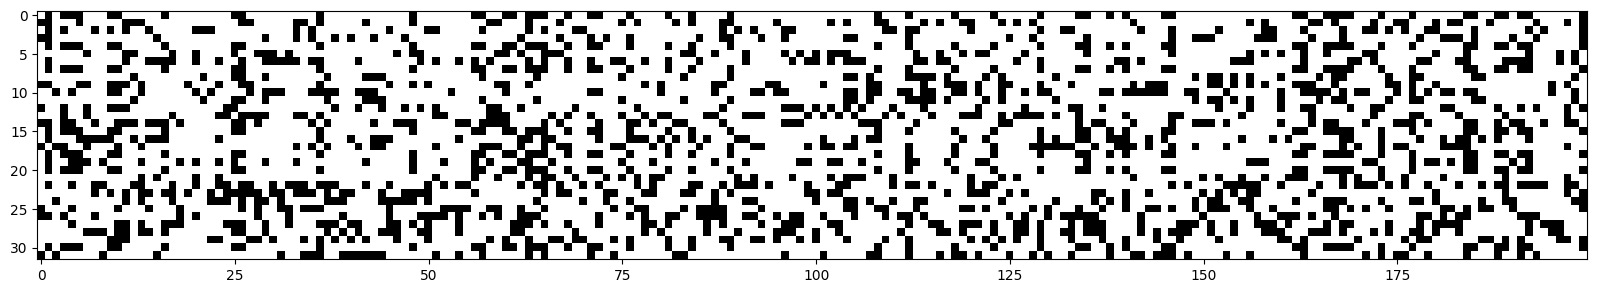

In [87]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

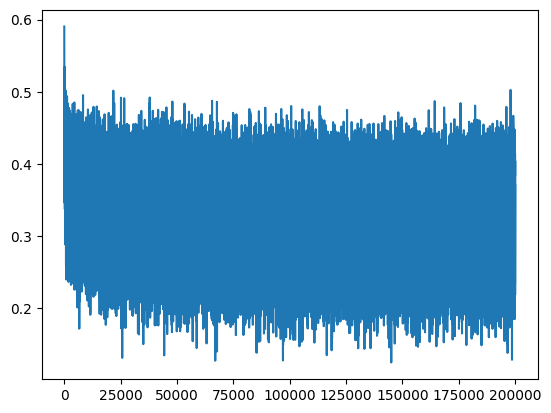

In [89]:
plt.plot(lossi)

(array([2422.,  139.,  102.,   73.,   38.,   42.,   28.,   21.,   34.,
          24.,   21.,   11.,   14.,   17.,   17.,   22.,    9.,   14.,
          18.,    7.,   15.,    9.,   14.,   13.,    9.,   10.,   14.,
          10.,   17.,   10.,   14.,   14.,    8.,   22.,   25.,   18.,
          21.,   15.,   21.,   24.,   30.,   26.,   20.,   22.,   31.,
          37.,   73.,   95.,  127., 2563.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

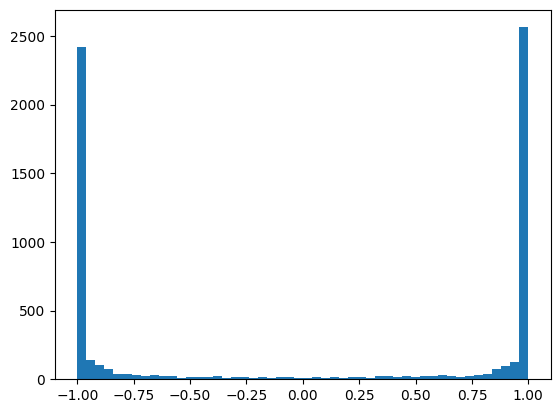

In [73]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   1.,   1.,   4.,   7.,  12.,  13.,  17.,  22.,  20.,
         30.,  63.,  75., 103.,  93., 153., 203., 215., 256., 293., 311.,
        421., 395., 294., 292., 380., 328., 335., 301., 308., 270., 248.,
        179., 181., 152., 116.,  73.,  67.,  44.,  40.,  30.,  14.,  18.,
          6.,   6.,   3.,   2.,   1.,   2.]),
 array([-25.44430733, -24.43758354, -23.43085976, -22.42413597,
        -21.41741219, -20.4106884 , -19.40396461, -18.39724083,
        -17.39051704, -16.38379326, -15.37706947, -14.37034569,
        -13.3636219 , -12.35689812, -11.35017433, -10.34345055,
         -9.33672676,  -8.33000298,  -7.32327919,  -6.3165554 ,
         -5.30983162,  -4.30310783,  -3.29638405,  -2.28966026,
         -1.28293648,  -0.27621269,   0.73051109,   1.73723488,
          2.74395866,   3.75068245,   4.75740623,   5.76413002,
          6.77085381,   7.77757759,   8.78430138,   9.79102516,
         10.79774895,  11.80447273,  12.81119652,  13.8179203 ,
         14.824644

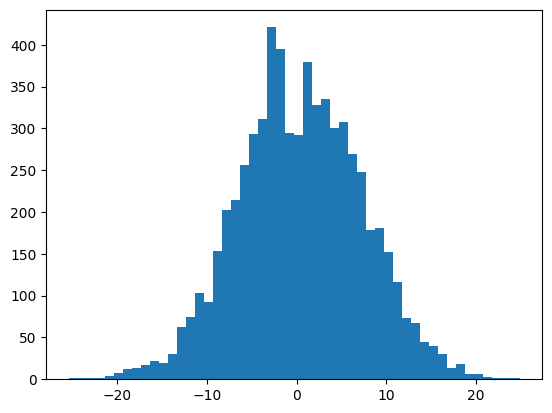

In [90]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [100]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running  + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')



train 2.131807565689087
val 2.154822587966919
test 2.159374713897705


In [77]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahzato.
harlik.
mrix.
taty.
salaysie.
rahnen.
delynn.
jarqui.
nellara.
chaiir.
kaleigh.
ham.
joce.
quint.
shon.
walianni.
waterri.
jaryxia.
kaellinsley.
dae.


tensor(-0.0066) tensor(1.0003)
tensor(0.0025) tensor(0.9949)


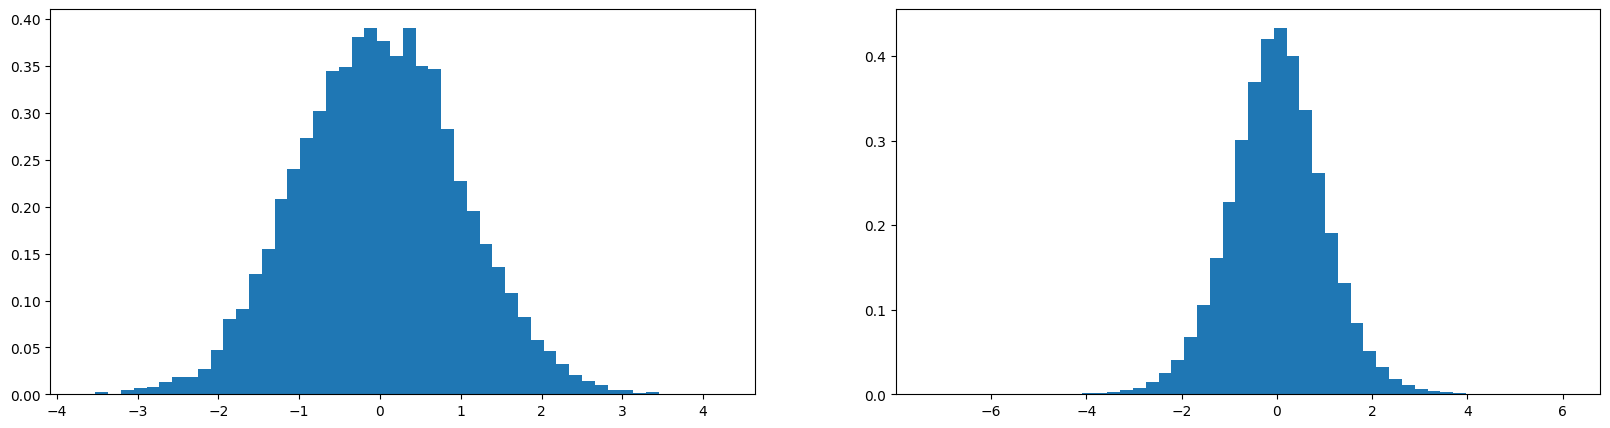

In [84]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);
